In [1]:
from IPython.display import display, set_matplotlib_formats
from collections import Counter
from itertools import chain
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping

import os


Using TensorFlow backend.


In [2]:
cd Data

C:\Users\Admin\BE PROJECT\Data


# Introduction
This dataset consists of 3,988 articles, some of which are fake news. We want to be able to predict if an article is a fake news.
**1.** First of all, without knowledge about data, we need to understand which class is associated with fake news.
**2.** Secondly, we will clean the data.  
**3.** Thirdly, we will apply word embedding.
**4.** Finally, we will use a LSTM to classify the articles.  

In [8]:
df = pd.read_csv('data.csv')
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# Data analysis
Here we will answer three questions:
- Is fake news class 0 or 1?
- How was the dataset created?  
- Is the dataset balanced?

One can think that the labels were created directly from the websites containing the articles. To check this, we extract websites from URLs and look at the count of each class.

In [9]:
df['website'] = df.URLs.apply(lambda x: x.split('/')[2])
df.pivot_table(index = 'website', columns = 'Label', values = 'URLs', aggfunc='count').fillna(0).astype(int)

Label,0,1
website,,
abcnews.go.com,0,57
api.content-ad.net,2,0
beforeitsnews.com,1694,0
bleacherreport.com,0,8
clarivate.com,0,3
cnn.it,0,1
dailybuzzlive.com,99,0
edition.cnn.com,0,16
inhealth.cnn.com,0,14


1. No website publishes both fake news and real news. The labels were most likely created from the websites the articles originated from.

2. Looking at the websites, we can easily assume that 
    - **Fake news are labelled 0** (e.g. beforeitsnews.com).
    - **True news are labelled 1** (e.g. bbc.com).  

We should therefore not use URLs to make predictions, which seems logical. The last question is, how balanced is the dataset?

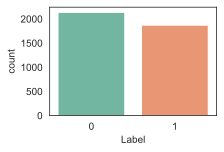

In [10]:
sns.set_style("white")
sns.set_palette('Set2')
fig, ax=plt.subplots(figsize=(3, 2))
ax = sns.countplot(df.Label)
fig.show()

The dataset is balanced, we can directly use it.

# Data Preprocessing
Because we have both the title and the body, by concatenating the two, we will use both in our model. One can imagine that a model using only titles may also be feasible, but would probably be less precise.

In [11]:
df['text'] = df['Headline'] + " " + df['Body']
df = df.drop(columns = ['Headline', 'Body'])
df = df.loc[~df['text'].isna()] # 

In [12]:
df

,URLs,Label,website,text
0,http://www.bbc.com/news/world-us-canada-414191...,1,www.bbc.com,Four ways Bob Corker skewered Donald Trump Ima...
1,https://www.reuters.com/article/us-filmfestiva...,1,www.reuters.com,Linklater's war veteran comedy speaks to moder...
2,https://www.nytimes.com/2017/10/09/us/politics...,1,www.nytimes.com,Trump’s Fight With Corker Jeopardizes His Legi...
3,https://www.reuters.com/article/us-mexico-oil-...,1,www.reuters.com,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,1,www.cnn.com,Jason Aldean opens 'SNL' with Vegas tribute Co...
...,...,...,...,...
4003,http://beforeitsnews.com/u-s-politics/2017/10/...,0,beforeitsnews.com,CNN and Globalist Exposed - Steve Quayle and A...
4004,http://beforeitsnews.com/sports/2017/09/trends...,0,beforeitsnews.com,Trends to Watch Trends to Watch\n% of readers ...
4005,http://beforeitsnews.com/u-s-politics/2017/10/...,0,beforeitsnews.com,Trump Jr. Is Soon To Give A 30-Minute Speech F...
4007,https://www.reuters.com/article/us-china-pharm...,1,www.reuters.com,China to accept overseas trial data in bid to ...


In [3]:
df = pd.read_csv('final_used.csv')

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.dropna(inplace=True)

In [6]:
 df

,Label,text
0,1,four ways bob corker skewered donald trump ima...
1,1,linklaters war veteran comedy speaks modern am...
2,1,trump’s fight corker jeopardizes legislative a...
3,1,egypts cheiron wins tieup pemex mexican onshor...
4,1,jason aldean opens snl vegas tribute country s...
...,...,...
46561,0,rapper t i unloaded black celebrities met dona...
46562,0,green bay packers lost washington redskins wee...
46563,0,macy’s today grew union several great names am...
46564,1,nato russia hold parallel exercises balkans p...


21/3988 = 0.5% of rows contain neither headline nor body. We remove these rows.

**The next step is to clean the data:**
1. Text is converted to lowercase.
2. URLs are removed: due to internal website references, the model risks learning that an article containing a link to beforeitsnews.com is fake news. But we don't want the model to depend on the website.
3. Braquets are removed.
4. Stopwords are removed.
5. Some characters are removed: The stopwords filtering only filtered the words. However, some punctuation marks is stuck to the words, such as "Thus,": the comma is not a separate word and therefore was not deleted.

In [7]:
stop_words = set(stopwords.words('english'))
to_remove = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.update(to_remove)
print('Number of stopwords:', len(stop_words))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\[[^]]*\]', '', text)
    text = (" ").join([word for word in text.split() if not word in stop_words])
    text = "".join([char for char in text if not char in to_remove])
    return text

df['text'] = df['text'].apply(clean_text)

Number of stopwords: 226


One of the simplest methods of text classification techniques is to associate each word with a frequency for the two (or more) classes. We can first look at the difference in the distribution of the most frequent words in the two classes:

In [8]:
def print_frequency(words, name):
    counter = Counter(chain.from_iterable(words))
    df_word_distribution = pd.DataFrame(counter.values(), index = counter.keys(), columns = ['Frequency'])
    df_word_distribution.index = df_word_distribution.index.set_names(name)
    df_word_distribution = df_word_distribution.sort_values(by = 'Frequency', ascending = False, axis=0)[:15]
    df_word_distribution = df_word_distribution.pivot_table(columns = name)
    df_word_distribution = df_word_distribution.sort_values(by = 'Frequency', ascending = False, axis=1)
    display(df_word_distribution)
    
words_fake = [s.split() for s in df.loc[df.Label == 0]['text']]
words_true = [s.split() for s in df.loc[df.Label == 1]['text']]
print_frequency(words_fake, 'Fake')
print_frequency(words_true, 'True')

Fake,said,mr,—,trump,one,would,people,new,us,like,also,clinton,president,time,could
Frequency,83003,66648,48689,48565,41956,41268,39159,32655,31739,28956,28425,25816,25284,22962,21546


True,us,said,trump,people,one,would,clinton,new,also,hillary,like,time,world,even,state
Frequency,22138,19549,18250,17519,17447,16738,15635,12453,11533,11133,11052,9920,9712,9484,9218


The distribution of words differs between the two classes. Building a model that only uses word frequency is possible, but we lose the meaning of the text, which also contains useful information. Therefore, we will instead move to a Word2Vec + LSTM solution, capable of grasping this meaning. We will start by implementing the Word2Vec part.
# Word2Vec

Word2Vec is a very popular word embedding technique which uses neural network, and that was developed in 2013 by Google.
There are two way of using the word embedding:
1. Using word embedding in an unsupervised way: This means that, based on the sentences we have, the model tries to capture the context of a word in a document, that is, the relation to other words, semantic and syntactic similarities, etc...
2. Using word embedding as a first layer in the neural network/LSTM. This means that the weights are learned through backpropagation of the classification error. Therefore, weights are learned by backpropagating the classification error. The model does not necessarily try to capture the context of a word in a document, it adjusts the weights only in such a way as to reduce loss. 


**We will use here the first method.** It is faster because the embedding only needs to be done once, and not on each iteration of the LSTM training. An advantage of the first method is the possibility of using pre-trained models, that is, models which have already associated the words with vectors. We haven't explored this solution here.

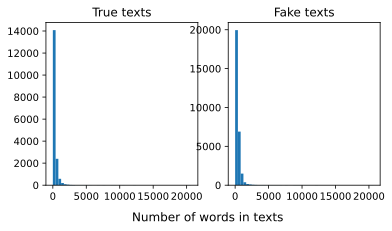

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,3))
text_len=df[df.Label==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins = 50)
ax1.set_title('True texts')
text_len=df[df.Label==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins = 50)
ax2.set_title('Fake texts')
fig.suptitle('Number of words in texts', y=0)
fig.show()

We can see that fake news texts tend to be shorter. A very large majority of texts are less than 1000 words long, so we can define a length of 1000 words for all texts, by adding a padding to texts of less than 1000 words and truncating those of more than 1000 words.

Given that the embedding requires a training, we keep aside a test set to test our model once finalized.

In [10]:
text_train, text_test, y_train, y_test = train_test_split(df['text'], df['Label'], test_size = 0.002, random_state = 42) 

We first fit our Word2Vec model on the training articles.   
We also tokenize the words of the articles, *i.e.* we associate a number to each word (the more frequent is the word, the lower is the number). The tokenized articles are then all set at the same length, thanks to padding and truncating.

In [11]:
size_embedding = 200 #Dimensionality of the feature vectors
windows = 2 #Maximum distance between the current and predicted word within a sentence
min_count = 1 #Ignores words with total frequency lower than this
maxlen = 1000 #Length decided for the text (adjusted by padding and truncating)

text_train_splited = [article.split() for article in text_train]
w2v_model = gensim.models.Word2Vec(sentences = text_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_splited)
text_train_tok = tokenizer.texts_to_sequences(text_train_splited)
word_index = tokenizer.word_index
print('Sive of vocabulary: ', len(word_index))

text_train_tok_pad = pad_sequences(text_train_tok, maxlen=maxlen)

Sive of vocabulary:  251904


We have to generate a matrix containing the weights of the embedding layer of the model. *w2v_to_keras_weights* returns the weight matrix with a row per word, and each row is the vector associated with the word.

The matrix shape is *(nb of words in the vocab +1, Dimensionality of the feature vectors)*.
The first row only contains the vector [0 ... 0], and is here for the never seen words (words not in the training set).

In [12]:
def w2v_to_keras_weights(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, size_embedding))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

embedding_vectors = w2v_to_keras_weights(w2v_model, word_index)

# Training the model
We will use a simple LSTM. We do not want the model to modify the weights determined by the Word2Vec model, so we set the trainable parameter to False.

In [18]:
def set_model(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=maxlen, 
                        trainable=False))
    model.add(LSTM(units=32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [20]:
model = set_model(embedding_vectors = embedding_vectors)
model.summary()

history = model.fit(text_train_tok_pad, y_train, validation_split=0.2, epochs=20, batch_size = 32, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         47084400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 47,114,257
Trainable params: 29,857
Non-trainable params: 47,084,400
_________________________________________________________________
Train on 29796 samples, validate on 7449 samples
Epoch 1/20
29796/29796 [==============================] - 511s 17ms/step - loss: 0.6116 - acc: 0.6386 - val_loss: 0.5956 - val_acc: 0.6483
Epoch 2/20
29796/29796 [==============================] - 494s 17ms/step - loss: 0.5779 - acc: 0.6559 - val_loss: 0.5940 - val_acc: 0.6535
Epoch 3/20
29796/29796 [================

In [22]:





model.save('lstmmodellayer1onfinaldata.h5')  





In [16]:
dropout = 0.4
lstm_dim = 128

model1 = Sequential()
model1.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=maxlen, 
                        trainable=False))
model1.add(Dropout(dropout))

model1.add(Bidirectional(LSTM(lstm_dim), merge_mode = 'sum'))
model1.add(Dropout(dropout))

model1.add(Dense(units = 128, activation = 'relu'))
model1.add(Dropout(dropout))

model1.add(Dense(units = 1, activation = 'sigmoid'))
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 200)         50381000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000, 200)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               336896    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [17]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [19]:
history = model1.fit(text_train_tok_pad, y_train, validation_split=0.1, epochs=10, batch_size = 32, verbose = 1)

Train on 41816 samples, validate on 4647 samples
Epoch 1/10
41816/41816 [==============================] - 1435s 34ms/step - loss: 0.6167 - accuracy: 0.6366 - val_loss: 0.5762 - val_accuracy: 0.6637
Epoch 2/10
41816/41816 [==============================] - 1428s 34ms/step - loss: 0.5759 - accuracy: 0.6543 - val_loss: 0.5603 - val_accuracy: 0.6624
Epoch 3/10
41816/41816 [==============================] - 1430s 34ms/step - loss: 0.5503 - accuracy: 0.6595 - val_loss: 0.5496 - val_accuracy: 0.6617
Epoch 4/10
41816/41816 [==============================] - 1431s 34ms/step - loss: 0.5401 - accuracy: 0.6627 - val_loss: 0.5423 - val_accuracy: 0.6705
Epoch 5/10
41816/41816 [==============================] - 1431s 34ms/step - loss: 0.5326 - accuracy: 0.6671 - val_loss: 0.5345 - val_accuracy: 0.6682
Epoch 6/10
41816/41816 [==============================] - 1434s 34ms/step - loss: 0.5275 - accuracy: 0.6688 - val_loss: 0.5294 - val_accuracy: 0.6766
Epoch 7/10
41816/41816 [===========================

In [20]:





model1.save('bidirlstmmodelonfinaldata.h5')  





In [39]:
def set_model_new(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=maxlen, 
                        trainable=False))
    model.add(LSTM(units=32))
    model.add(LSTM(units=16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [ ]:
model = set_model_new(embedding_vectors = embedding_vectors)
model.summary()

In [ ]:
history = model.fit(text_train_tok_pad, y_train, epochs=20, batch_size = 32, verbose = 1)

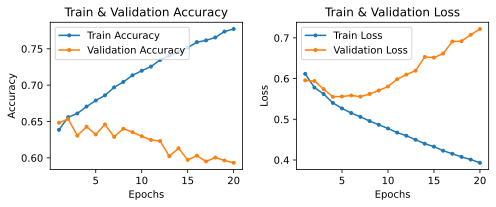

In [23]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
    
plot_loss_epochs(history)

# Scores on test set

First, we will re-train the model on 100% of the training set - We previously kept 20% for the validation.

              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99       450
    Not Fake       0.97      0.99      0.98       348

    accuracy                           0.98       798
   macro avg       0.98      0.99      0.98       798
weighted avg       0.99      0.98      0.98       798



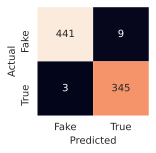

In [23]:
text_train_splited = [article.split() for article in text_test]
text_test_tok = tokenizer.texts_to_sequences(text_train_splited)
text_test_tok_pad = pad_sequences(text_test_tok, maxlen=maxlen)
pred = (model.predict(text_test_tok_pad) > 0.5).astype("int32")

print(classification_report(y_test, pred, target_names = ['Fake','Not Fake'])) 
cm = pd.DataFrame(confusion_matrix(y_test,pred))

fig , ax = plt.subplots(figsize = (2,2))
ax = sns.heatmap(cm, annot = True, xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'], cbar = False, fmt='')
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); fig.show()

In implementations using this type of fake news filtering, it can be more problematic to have false positives, that is, real news described as false, rather than false negatives, and that can be filtered for no reason. Using a **neural network with uncertainty** can provide a way to adjust the false positive rate, instead of just taking the sigmoid output as is the case here, without any information about the confidence of the output.

The biggest problem with this challenge is the lack of data: train set is constituted of 3190 observations (minus 20% for the validation), and test set is constituted of 798 observations.
The h5 file is 136 MB but seems empty. We can think of downloading more data thanks to a **web scraping algorithm** applied on the above websites.